In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# imrport hippylib as hp

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)
import ipywidgets as wd

# import cbayes as cb
import cbayes.sample as samp
import cbayes.solve as solve
import cbayes.distributions as ds

np.random.seed(seed=1)

In [245]:
# Plotting and evaluation utility functions. 
y_loc_measurements = 0.2
def eval_on_grid(u, n=10):
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)
    X,Y = np.meshgrid(x,y)
    xx = X.flatten()
    yy = Y.flatten()
    return np.array([u(x,y) for x, y in zip(xx,yy)])

def plot_state(u2,flocs, savefile=None):
    n = int(np.sqrt(u2.shape))
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)
    plt.figure(figsize=(15,12))
    vmin = -0.0075
    vmax = 0.0075
    plt.contourf(x, y, u2.reshape(n,n), alpha=0.8, vmin=vmin, vmax=vmax)
    plt.pcolor(x, y, u2.reshape(n,n), alpha=0.5, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.scatter(flocs[:,0], flocs[:,1], marker='x', c='white', s=200, label='source locations')
#     plt.legend(fontsize=18)
    if savefile is not None:
        plt.savefig(savefile)
    plt.show()
    
def compare_state(u_eval, m_eval, flocs, num_sensors=10):
    n = int(np.sqrt(u_eval.shape))
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)

    vmin = -0.0075
    vmax = 0.0075
    
    # plot solution
    fig, axs = plt.subplots(ncols=2, figsize=(20, 9))
    im = axs[0].contourf(x, y, u_eval.reshape(n,n), alpha=0.8)#, vmin=vmin, vmax=vmax)
    axs[0].pcolor(x, y, u_eval.reshape(n,n), alpha=0.5)#, vmin=vmin, vmax=vmax)
    axs[0].scatter(flocs[:,0], flocs[:,1], marker='x', c='white', s=200, label='source locations')
    cax = fig.add_axes([0.4875, 0.125, .0075, 0.75])
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    # plot truth
    im2 = axs[1].contourf(x, y, m_eval.reshape(n,n), alpha=0.8)
    axs[1].axis('off')  
    cax2 = fig.add_axes([0.9075, 0.125, .0075, 0.75])
    fig.colorbar(im2, cax=cax2, orientation='vertical')
    
    if num_sensors == 1:
        x_samps = np.array([0.5])
    else:
        x_samps = np.linspace(0.25, 0.75, num_sensors)
    y_samps = y_loc_measurements*np.ones(num_sensors) # sample along a straight line
    sample_locs = np.vstack([x_samps, y_samps]).T
    
    axs[0].scatter(x_samps, y_samps, c='white', marker='o')
    
    # show plot
    plt.show()
    return fig, axs

In [3]:
def f_expr(Vh, x,y):
    f = dl.interpolate(dl.Expression("std::exp(-pow(x[0]-{0},2)/0.1)*std::exp(-pow(x[1]-{1},2)/0.1)".format(x,y), degree=5), Vh)
    return f

def generate_f(Vh, flocs, weights):
    f = weights[0]*f_expr(Vh, flocs[0][0], flocs[0][1])
    for floc, weight in zip(flocs[1:], weights[1:]):
        f += weight*f_expr(Vh, floc[0], floc[1])
    return f

class MaterialPropertyExpression(dl.Expression):
    def __init__(self, r=0.25, c1=60.0, c2=40.0, xc=0.5, yc=0.5, **kwargs):
        self.r = r
        self.c1 = c1
        self.c2 = c2
        self.xc = xc # center of intrusion
        self.yc = yc
        
    def eval(self, values, x):
        c1 = self.c1
        c2 = self.c2
        r = self.r
        values[0] = np.log(c1 - c2*( np.power(x[0] - self.xc, 2) + np.power(x[1] - self.yc, 2) < np.power(r, 2) ) ) # piecewise constant
    
    def value_shape(self):
        return (1,)
    
def solve_system(Vh, f, omega_const, r):
    def boundary(x, on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vh, dl.Constant(0.0), boundary)
    u = dl.Function(Vh)
    u_trial = dl.TrialFunction(Vh)
    u_test  = dl.TestFunction(Vh)
    omega = dl.Constant(omega_const)
    mtrue = MaterialPropertyExpression(r, element=Vh.ufl_element() )
    
    a = (-dl.inner(dl.grad(u_trial), dl.grad(u_test)) + omega*omega*dl.inner(dl.exp(2*mtrue)*u_trial, u_test)) * dl.dx
    L = -f * u_test * dl.dx
    A,b = dl.assemble_system(a, L, bc_state)
    dl.solve(A, u.vector(), b)
    return u

## Define a Test Problem

In [4]:
# ndim = 2
nx = 50
ny = 50
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
# Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
# Vh = [Vh2, Vh1, Vh2]
# print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
#     Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()) )

# declist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
declist = [0.1, 0.9]
flocs = np.array([[i,j] for i in declist for j in declist])

## Take advantage of linearity in $f$.

In [5]:
omega_const = 0.5
r = 0.25
n = 120
std = 0.005
ulist = [solve_system(Vh2, generate_f(Vh2, [floc], [1]), omega_const, r) for floc in flocs]
U = np.array([eval_on_grid(u,n) for u in ulist]).T
weights = np.random.normal(1,std,len(flocs))
u2 = U @ np.array(weights)
mtrue = MaterialPropertyExpression(element=Vh2.ufl_element())

### Demonstrate that the two ways of defining the expression are equivalent.

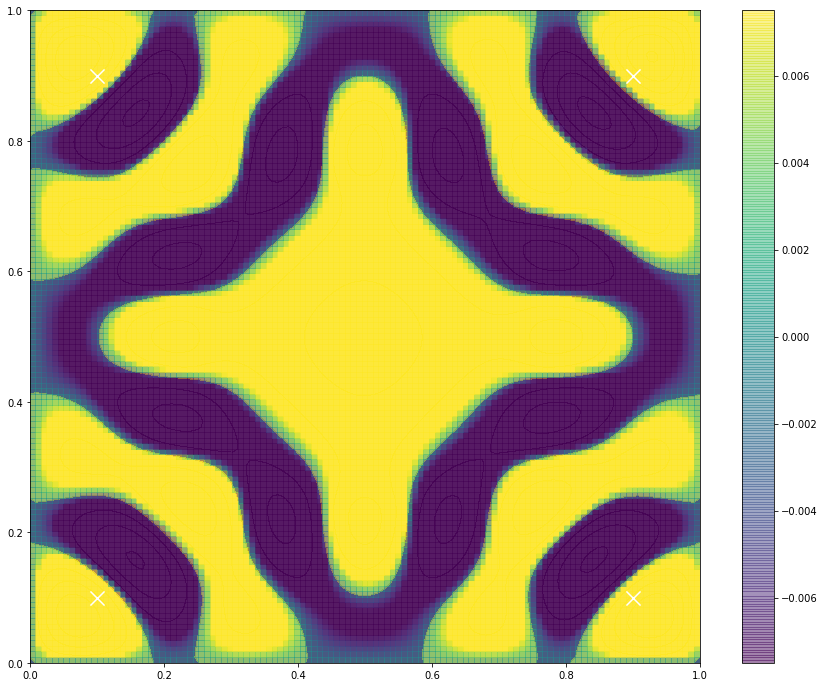

In [6]:
f = generate_f(Vh2, flocs, weights)
u = solve_system(Vh2, f, omega_const, r)
ug = eval_on_grid(u, n)
plot_state(ug, flocs, savefile='testsave.png')

Note that the error is close to machine-$\epsilon$

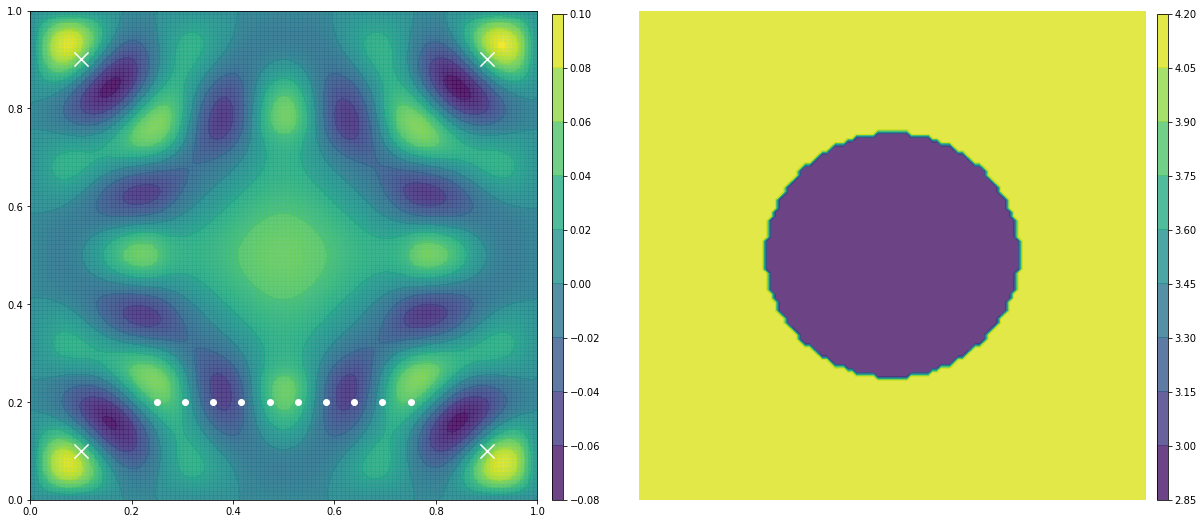

(<matplotlib.figure.Figure at 0x7fa1fb4f79b0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1fbcc5828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa1fbcec4e0>], dtype=object))

In [246]:
m = eval_on_grid(mtrue, n)
compare_state(u2, m, flocs)
# compare_state(u2-ug, m, flocs)

# Demonstrated that it works, now let's make a GUI

In [247]:
def wrap_problem(nx=50, r=0.2, omega_const=0.5, num_sensors = 10, std=0.005, n=100, num_f=4, seed=1, show_plot=False):
    ndim = 2
    ny = nx
    mesh = dl.UnitSquareMesh(nx, ny)
    Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
#     Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
#     Vh = [Vh2, Vh1, Vh2]
#     print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
#         Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )
    
    declist = np.linspace(0.1, 0.9, num_f)
    
    flocs = np.array([[i,j] for i in declist for j in declist])
    
    np.random.seed(seed)
    weights = np.ones(len(flocs))
#     noise_std = std # if you're allowing the sources to be random.
#     weights = np.random.normal(0,noise_std,len(flocs))
    
    # other method
#     ulist = [solve_system(Vh2, generate_f(Vh2, [floc], [1]), omega_const, r) for floc in flocs] # solve system for each source
#     U = np.array([eval_on_grid(u,n) for u in ulist]).T # evaluate on a mesh
#     u2 = U @ np.array(weights) # sum state variables over all source terms.
    
    # cleaner method - also quite a bit faster post-compilation.
    f = generate_f(Vh2, flocs, weights)
    u = solve_system(Vh2, f, omega_const, r)
    u_eval = eval_on_grid(u, n)
    mtrue = MaterialPropertyExpression(r, element=Vh2.ufl_element())
    m_eval = eval_on_grid(mtrue, n)
    
    if show_plot:
        fg, ax = compare_state(u_eval, m_eval, flocs, num_sensors)
    
    ## Measurements
    if num_sensors == 1:
        x_samps = np.array([0.5])
    else:
        x_samps = np.linspace(0.25, 0.75, num_sensors)
    y_samps = y_loc_measurements*np.ones(num_sensors) # sample along a straight line
    sample_locs = np.vstack([x_samps, y_samps]).T
    
    u_eval = np.empty( (num_sensors, 1) ) 
    for i in range(num_sensors):
        u_eval[i] = u(*sample_locs[i,:])
    
    return u_eval
    
    

In [248]:
W_nx = wd.IntSlider(value=50, min=20, max=100, step=2, continuous_update=False)
# W_nx = wd.fixed(value=120)
W_r = wd.FloatSlider(value=0.25, min=0.0, max=0.5, step=0.05, continuous_update=False)
# omega_options = [0.0125, 0.25, 0.5, 1.0, 2.0, 4.0]

W_omega_const = wd.SelectionSlider(value=0.5, options=omega_options, continuous_update=False)
W_num_sensors = wd.IntSlider(value=10, min=1, max=20, step=1, continuous_update=False)
sd_options = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
W_std = wd.SelectionSlider(value=0.005, options=sd_options, continuous_update=False)
W_n = wd.IntSlider(value=120, min=50, max=120, step=2, continuous_update=False)
# W_num_f = wd.IntSlider(value=2, min=1, max=20, step=1, continuous_update=False)
W_num_f = wd.fixed(value=2)
W_seed = wd.IntSlider(value=1, min=1, max=100, step=1, continuous_update=False)

kwds = {'nx': W_nx, 
        'r': W_r, 
        'omega_const': W_omega_const, 
        'num_sensors': W_num_sensors,
        'std': W_std,
        'n': W_n,
        'num_f': W_num_f,
        'seed': W_seed
       }


In [249]:
uv = wd.interact_manual(wrap_problem, show_plot=wd.fixed(True), **kwds)

interactive(children=(IntSlider(value=50, continuous_update=False, description='nx', min=20, step=2), FloatSli…

## Problem Summary

- Our space is $\Omega = [0,1]^2$.

- We have four fixed locations where we apply a unit point source forcing $f = \delta_A, A = \{0.1, 0.9\}\times\{0.1, 0.9\}$

- We will take `num_sensors` equispaced measurements in the interval $[0.25, 0.75]\times[0.1]$

- At first we will solve the 1D inverse problem with only the radius $r$ of the intrusion is uncertain.

- We do this for simplicity of visualizing the posterior in order to investigate the effect of the number of measurements taken and the frequencies $\omega$ over which we perform measurements.

- At first we will simply compare the solutions to the inverse problem under different frequencies.

- Time permitting, we will solve a sequence of inverse problems wherein we start at some initial $\omega_0$ and then measure at $\omega_i = 2^i \omega_0 \text{ for } i = 1, \dots, p$, feeding the posterior (or some approximation thereof) as the prior into the following inverse problem.


In [136]:
num_samples = int(1E2)
s_set = samp.sample_set((num_samples, 1))
s_set.set_dist(dim=0, distribution='beta', kwds={'loc': 0.1, 'scale': 0.3, 'a': 1, 'b': 1}) # the uncertain r
input_samples = s_set.generate_samples(seed=10)

# samp.map_samples_and_create_problem()

In [137]:
num_observations = 25 # num_sensors
omega_options = [0.25, 0.5, 1.0]
def model(lam):
    n_samps = lam.shape[0]
    omega_const = omega_options[1] # VERY IMPORTANT
    measurements = np.empty( (n_samps, num_observations*len(omega_options) ) )  # we need this to return N by num_obs/num_timesteps
    for i in range(n_samps):
            measurements[i,:] = np.hstack( [ wrap_problem(nx=50, r=lam[i,0], 
                                             omega_const=omega_const, 
                                             num_sensors = num_observations,  
                                             n=50, num_f=4).ravel() for omega_const in omega_options])
    
    return measurements

def MSE_generator(model, obs_data, sigma=None):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        M = len(obs_data)
        predictions = model(inputs)
        assert predictions.shape[1] == M
        residuals = predictions - obs_data
#         print(residuals.shape)
        if sigma is not None:
            QoI = (1./M)*np.sum( (residuals/sigma)**2, axis=1 )   # MSE
        else:
            QoI = (1./M)*np.sum( (residuals/obs_data)**2, axis=1 )  # MRSE
        return QoI
    return QoI_fun



In [138]:
# truefield = MaterialPropertyExpression(r=0.25, element=Vh2.ufl_element())
rtrue = 0.3
trueNoiseStd = 5E-2

synthetic_data = model(np.array(rtrue).reshape(-1,1))[0] + trueNoiseStd*np.random.randn(num_observations*len(omega_options))
# PtO_fun = MSE_generator(model, synthetic_data, trueNoiseStd)

In [140]:
p_set = samp.map_samples_and_create_problem(s_set, PtO_fun)
p_set.set_observed_dist('gamma', {'a':(num_observations*len(omega_options))/2, 'scale':2/(num_observations*len(omega_options))}, dim=0)


In [250]:
D = np.load('saved_runs_from_first_good_run2.npy').item() #10k samples
input_samples = D['input_samples']
output_samples = D['output_samples']
p_set.input.num_samples = input_samples.shape[0]
p_set.output.num_samples = output_samples.shape[0]
p_set.output.samples = output_samples
p_set.input.samples = input_samples
p_set.set_observed_dist('gamma', {'a':(num_observations*len(omega_options))/2, 'scale':2/(num_observations*len(omega_options))}, dim=0)


In [251]:
# output_samples = p_set.output.samples

In [252]:
p_set.compute_pushforward_dist(method='sk', kwds={'bandwidth': 1})
# p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

The difficulty here is the concentrated and spread out modes of the pushforward of the prior.

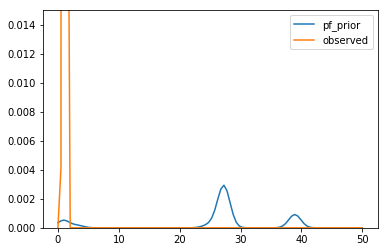

In [253]:
xx = np.linspace(0,50,100)
yy = pf_dist.pdf(xx)
plt.plot(xx, yy, label='pf_prior')
zz = p_set.observed_dist.pdf(xx)
plt.plot(xx, zz, label='observed')
plt.ylim([0,0.015])
plt.legend()
plt.show()

In [260]:
p_set.set_ratio() # expensive

In [261]:
solve.problem(p_set, seed=51)

In [262]:
accepted_inputs = p_set.input.samples[p_set.accept_inds,:]
print('num accepted:', len(accepted_inputs), 'mean:', np.mean(accepted_inputs))

num accepted: 13 mean: 0.299853109965


In [263]:
kde_approx_of_post = ds.skde(accepted_inputs, **{'bandwidth': 0.01})

Text(0.5,1,'posterior')

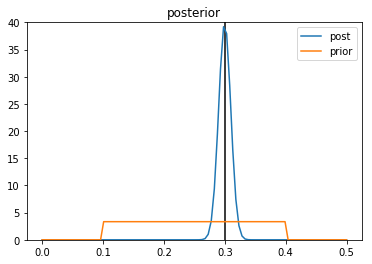

In [265]:
## plotting
xx = np.linspace(0,.5,100)
yy = kde_approx_of_post.pdf(xx)
zz = p_set.prior_dist.pdf(xx)

plt.figure
plt.plot(xx,yy, label='post')
# plt.scatter(input_samples,  p_set.ratio/p_set.ratio.max(), label='post', alpha=0.1)
plt.plot(xx,zz, label='prior')
plt.vlines(0.3, 0, 50)
plt.ylim([0,40])
plt.legend()
plt.title('posterior')
# plt.savefig('posterior_success_3omega250_25obs_1000samps_scatt.png')
# plt.savefig('posterior_success_3omega250_25obs_10000samps.png')

In [ ]:
D = {'input_samples': input_samples,
    'output_samples': output_samples,
    'accepted_inputs': accepted_inputs}
# np.save('saved_runs_from_first_good_run3.npy', D)


# Let's try to generate more accepted samples


In [223]:
num_new = 1000
new_input_samples = kde_approx_of_post.rvs(num_new)
new_output_samples = PtO_fun(new_input_samples)

In [ ]:
p_set.input.num_samples = num_new
p_set.output.num_samples = num_new
p_set.input.samples = new_input_samples

In [227]:
p_set.output.samples = new_ouput_samples.reshape(-1,1)

In [228]:
p_set.compute_pushforward_dist(method='sk', kwds={'bandwidth': 1})
p_set.set_ratio() # expensive

In [229]:
solve.problem(p_set)
new_accepted_inputs = p_set.input.samples[p_set.accept_inds,:]
print('num new accepted:', len(new_accepted_inputs), 'mean:', np.mean(new_accepted_inputs))
all_accepted = np.vstack([new_accepted_inputs, accepted_inputs])

num new accepted: 68 mean: 0.300730402985


In [235]:
kde_approx_of_post_new = ds.skde(all_accepted, **{'bandwidth': 0.01})

Text(0.5,1,'posterior')

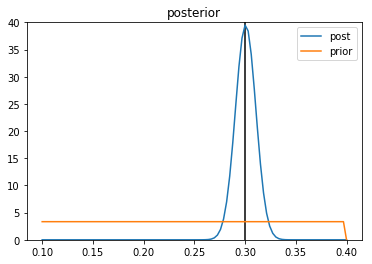

In [236]:
## plotting
xx = np.linspace(0.1,.4,100)
yy = kde_approx_of_post_new.pdf(xx)
zz = p_set.prior_dist.pdf(xx)

plt.plot(xx,yy, label='post')
# plt.scatter(input_samples,  p_set.ratio/p_set.ratio.max(), label='post', alpha=0.1)
plt.plot(xx,zz, label='prior')
plt.vlines(0.3, 0, 50)
plt.ylim([0,40])
plt.legend()
plt.title('posterior')
# plt.savefig('posterior_success_3omega250_25obs_1000samps_scatt.png')
# plt.savefig('posterior_success_3omega250_25obs_10000samps.png')

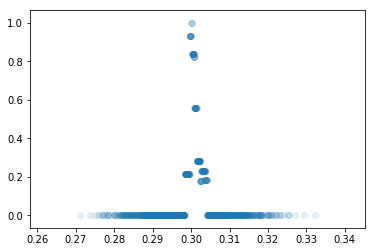

In [240]:
plt.scatter(new_input_samples,  p_set.ratio/p_set.ratio.max(), label='post', alpha=0.1)


In [242]:
D = {'input_samples': new_input_samples,
    'output_samples': new_output_samples,
    'accepted_inputs': new_accepted_inputs}
np.save('saved_runs_from_second_run.npy', D)